# Correlation Based Feature Selection (CFS)

This code walks through two examples of Correlation Based Feature Selection using the Segementation and Penguin datasets. Two search techniques are presented here, a Forward search and a Best First search. Some functions used in this notebook are from the CFS implementation by Jundong et al [1]

In [1]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from CFS import cfs, merit_calculation
from CFS_ForwardSearch import CFS_FS

## Example 1: CFS on Segmentation dataset

In [3]:
seg_data = pd.read_csv('Segmentation-all.csv')
print(seg_data.shape)
seg_data.head()

(2310, 20)


,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [4]:
y = seg_data.pop('Class').values
X_raw = seg_data.values
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, 
                                                       random_state=2, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
max_length = X_train.shape[0]
feat_num = X_train.shape[1]
X_train.shape, X_test.shape

((1155, 19), (1155, 19))

In [5]:
kNN = KNeighborsClassifier(n_neighbors=5)
kNN = kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_test)
acc = accuracy_score(y_pred,y_test)
cv_acc = cross_val_score(kNN, X_train, y_train, cv=8)

print("X_Val on training all features: {0:.3f}".format(cv_acc.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc)) 

X_Val on training all features: 0.946
Hold Out testing all features: 0.940


### Forward Search - CFS

Here, the best feature subset is found by finding the best single feature subset using merit score then adding all other features to this best feature and recomputing the merit. This process continues until merit score stops increasing.

In [6]:
merit_score_sel, sel_comb = CFS_FS(X_train, y_train)
print("Merit Score of Selected Features: " + str(merit_score_sel.values[0]))
print("Selected Feature index: " + str(sel_comb))

Merit Score of Selected Features: [0.43951449 0.44021037]
Selected Feature index: (17, 18)


In [7]:
# Print the selected features
feature_names_sel = seg_data.columns[np.array(sel_comb)]
feature_names_sel

Index(['SATURATION-MEAN', 'HUE-MEAN'], dtype='object')

#### Evaluate on Test Data

In [8]:
X_train_CFS_FS = X_train[:,sel_comb]
X_test_CFS_FS = X_test[:,sel_comb]

kNN_CFS_FS = kNN.fit(X_train_CFS_FS,y_train)

y_pred = kNN_CFS_FS.predict(X_test_CFS_FS)

acc_CFS_FS = accuracy_score(y_pred,y_test)
cv_acc_CFS_FS = cross_val_score(kNN_CFS_FS, X_train_CFS_FS, y_train, cv=8)

print("X_Val on training selected features: {0:.3f}".format(cv_acc_CFS_FS.mean())) 
print("Hold Out testing selected features: {0:.3f}".format(acc_CFS_FS)) 

X_Val on training selected features: 0.874
Hold Out testing selected features: 0.847


### Best First Search - CFS

The stopping criteria for this implementation is where 5 consecutive non-improving feature subsets are found.

In [9]:
Sel_feat = cfs(X_train,y_train)
Sel_feat = Sel_feat[Sel_feat!=-1]
Sel_feat

array([17, 18,  8,  6, 10,  9])

In [10]:
# Print the names of the features selected
feature_names_sel = seg_data.columns[Sel_feat]
feature_names_sel

Index(['SATURATION-MEAN', 'HUE-MEAN', 'HEDGE-SD', 'VEDGE-SD', 'RAWRED-MEAN',
       'INTENSITY-MEAN'],
      dtype='object')

In [11]:
# Find the merit score for the search space of the selected feature subsets
merit = []
cv_acc_CFS = []
for i in range(1,len(Sel_feat)+1):
    X_train_CFS = X_train[:,Sel_feat[0:i]]
    merit.insert(i, merit_calculation(X_train_CFS, y_train))
    kNN_CFS = kNN.fit(X_train_CFS,y_train)
    cv_acc_CFS.insert(i,cross_val_score(kNN_CFS, X_train_CFS, y_train, cv=8).mean())

merit

[0.43951448818147326,
 0.44021037374992716,
 0.43767125770380755,
 0.43619307358905546,
 0.43539938594841915,
 0.4339188253042891]

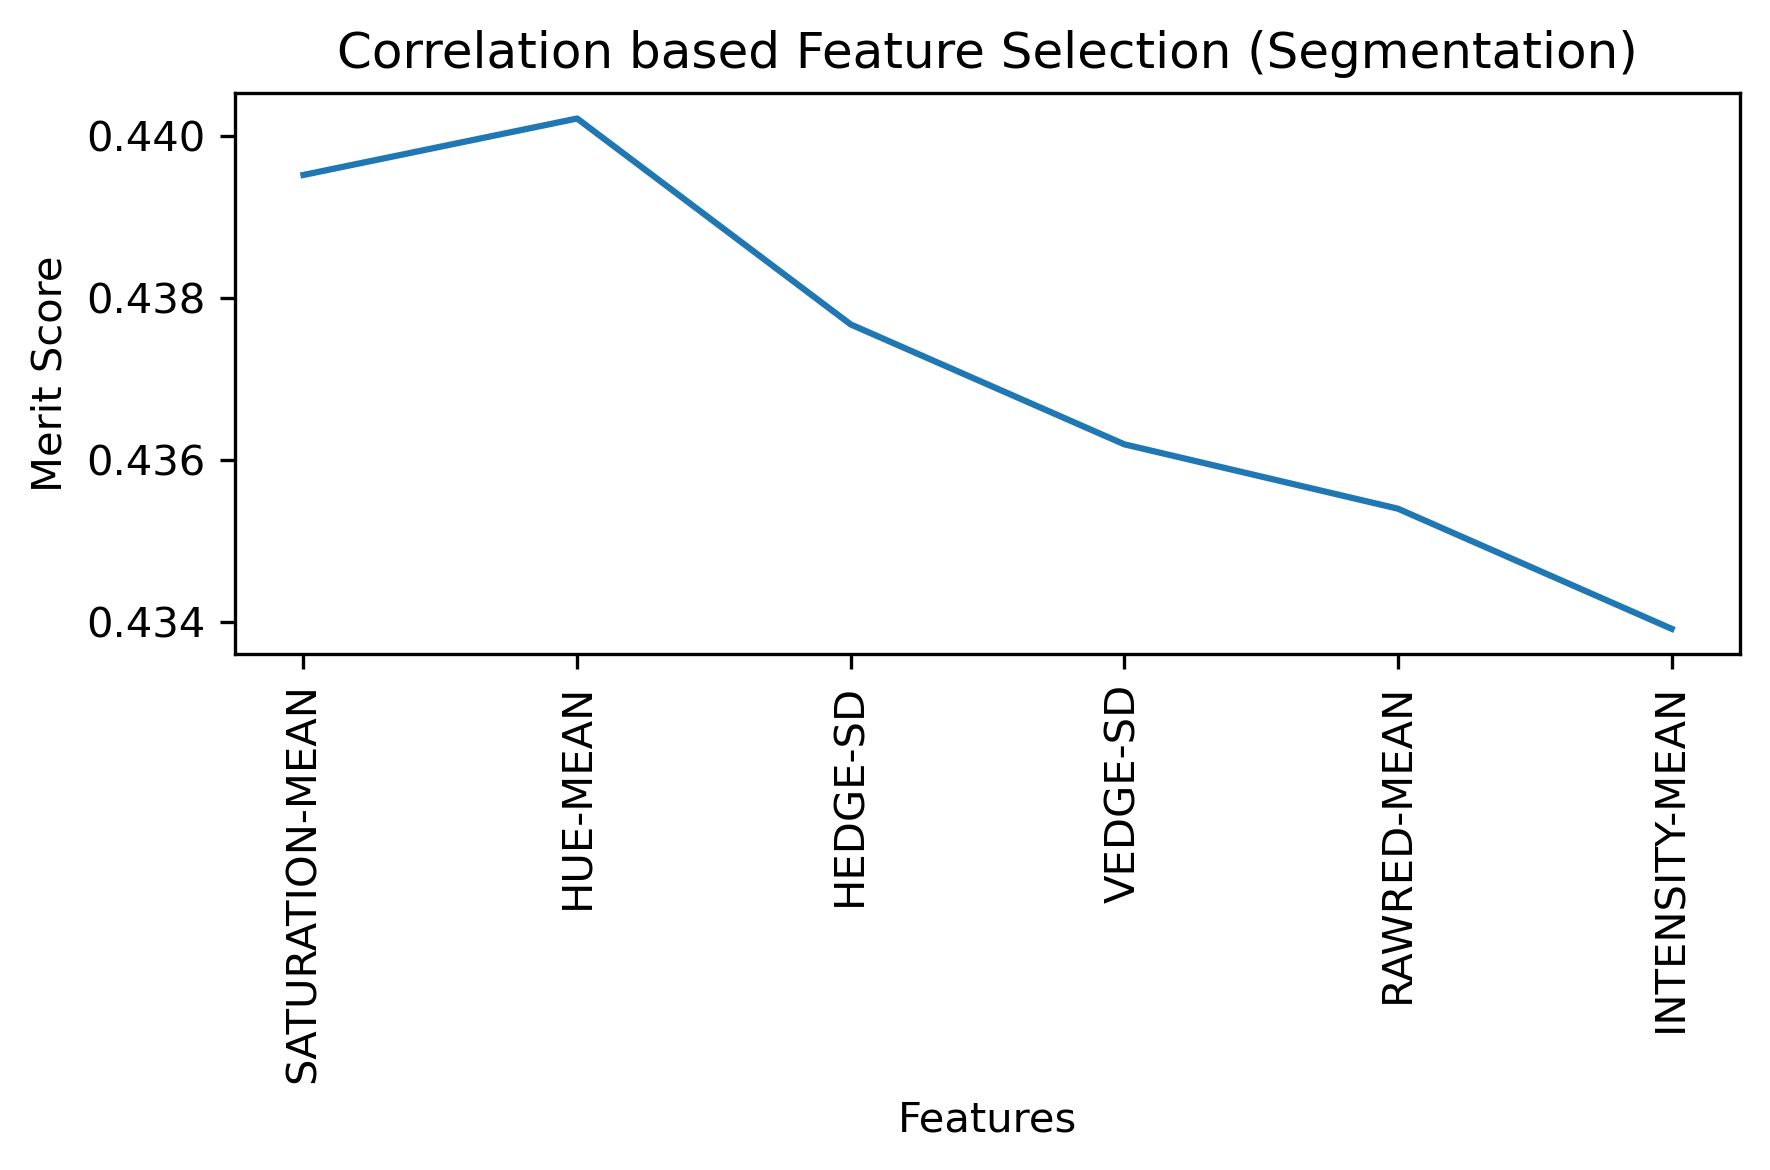

In [12]:
# Plot merit score as features are added
f1 = plt.figure(dpi = 300)
plt.plot(feature_names_sel, merit)
plt.title("Correlation based Feature Selection (Segmentation)")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Merit Score")
plt.tight_layout()

#### Evaluate on test data

In [13]:
X_test_CFS = X_test[:,Sel_feat]

kNN_CFS = kNN.fit(X_train_CFS,y_train)

y_pred = kNN_CFS.predict(X_test_CFS)

acc_CFS = accuracy_score(y_pred,y_test)
cv_acc_CFS = cross_val_score(kNN_CFS, X_train_CFS, y_train, cv=8)

print("X_Val on training selected features: {0:.3f}".format(cv_acc_CFS.mean())) 
print("Hold Out testing selected features: {0:.3f}".format(acc_CFS)) 

X_Val on training selected features: 0.902
Hold Out testing selected features: 0.887


### Plot Results

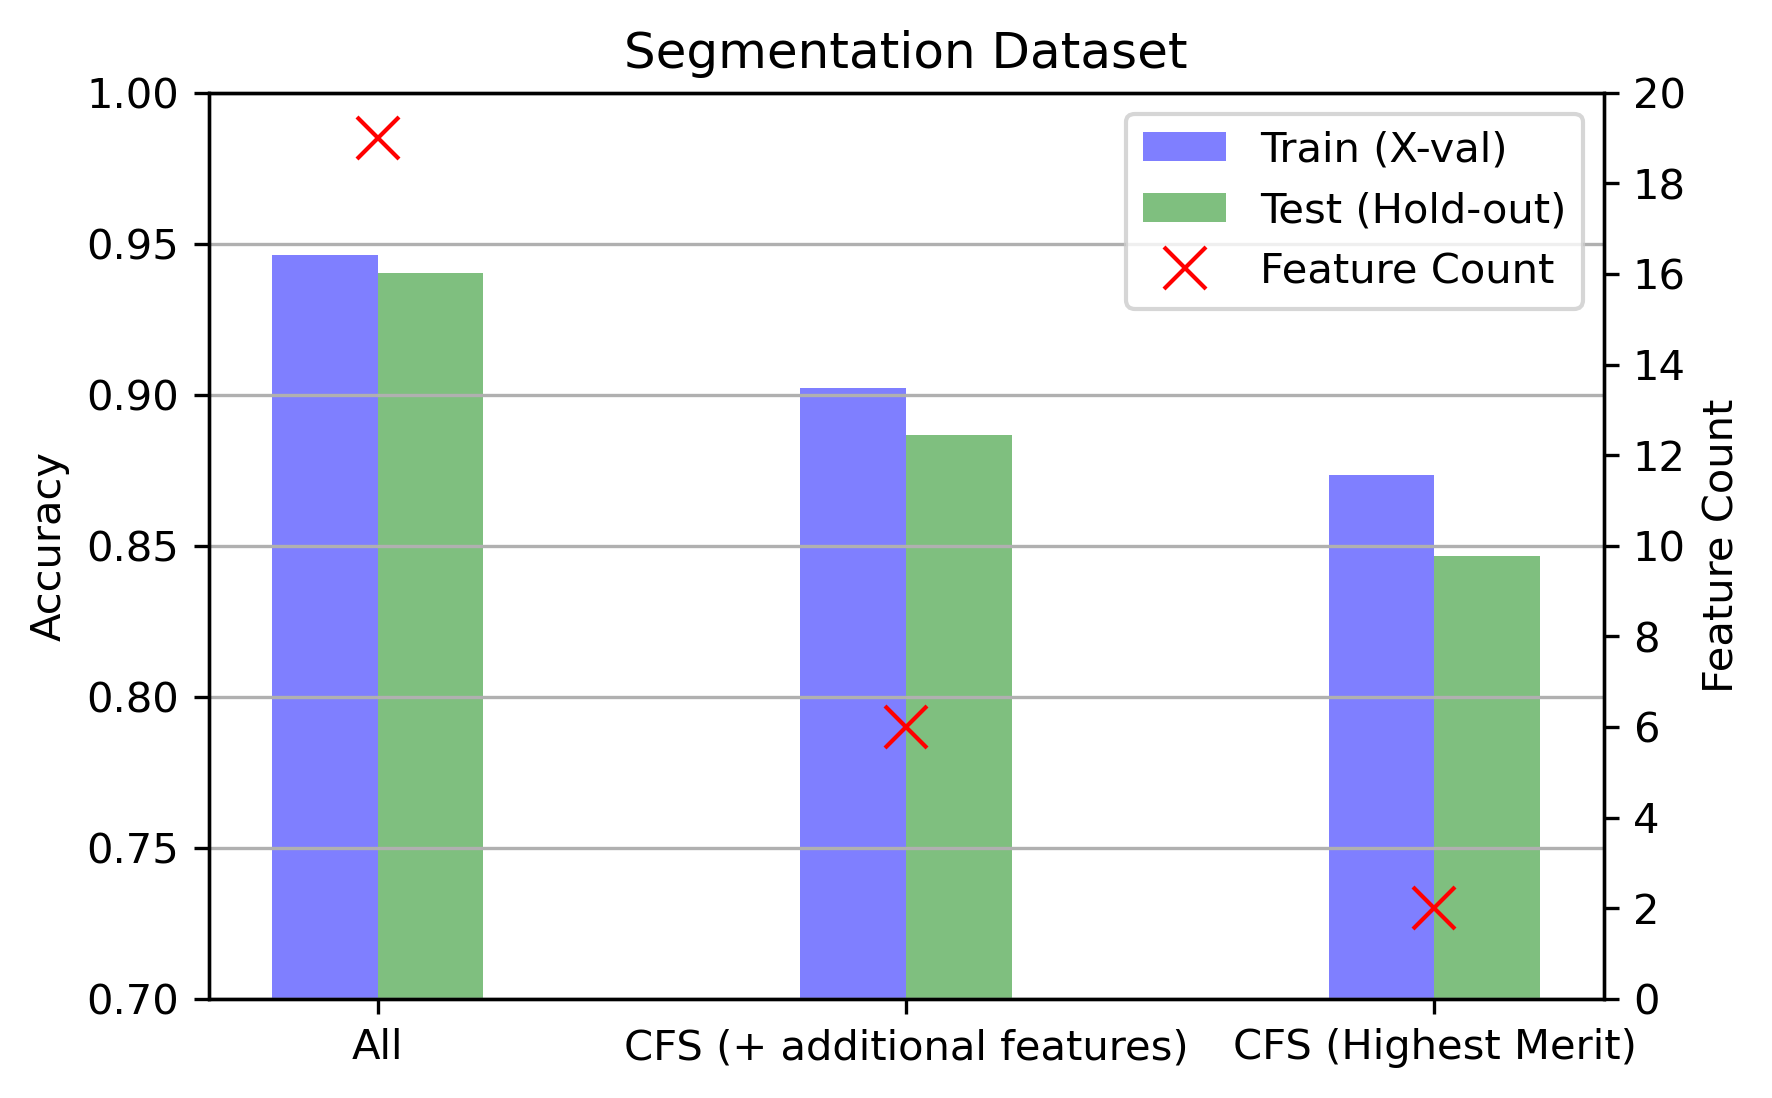

In [14]:
fig, ax = plt.subplots(dpi = 300)
width = 0.2

options = ['All', 'CFS (+ additional features)', 'CFS (Highest Merit)']
n_feat = [X_train.shape[1], X_train_CFS.shape[1], X_train_CFS_FS.shape[1]]
accs = [acc,acc_CFS, acc_CFS_FS]
xv = [cv_acc.mean(), cv_acc_CFS.mean(), cv_acc_CFS_FS.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label = 'Train (X-val)',
            color=['blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width/2, accs , width, align='center', label = 'Test (Hold-out)',
            color=['g','g','g'],alpha=0.5)

ax.set_ylim([0.7, 1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2],n_feat, color = 'red', label = 'Feature Count', marker = 'x', ms = 10, linewidth=0)
ax2.set_ylim([0, 20])

ax.grid(axis = 'y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc = 'upper right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Feature Count')
plt.title("Segmentation Dataset")
plt.show()

## Example 2: CFS on Penguins dataset

In [15]:
Peng_data = pd.read_csv('Penguins.csv').drop(columns = ['Unnamed: 0'])
print(Peng_data.shape)
Peng_data.head()

(333, 5)


,bill_length,bill_depth,flipper_length,body_mass,species
0,39.1,18.7,181.0,3750.0,Adelie
1,39.5,17.4,186.0,3800.0,Adelie
2,40.3,18.0,195.0,3250.0,Adelie
3,36.7,19.3,193.0,3450.0,Adelie
4,39.3,20.6,190.0,3650.0,Adelie


In [16]:
y = Peng_data.pop('species').values
X_raw = Peng_data.values
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, 
                                                       random_state=2, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
max_length = X_train.shape[0]
feat_num = X_train.shape[1]
X_train.shape, X_test.shape

((166, 4), (167, 4))

In [17]:
kNN = KNeighborsClassifier(n_neighbors=5)
kNN = kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_test)
acc = accuracy_score(y_pred,y_test)
cv_acc = cross_val_score(kNN, X_train, y_train, cv=8)

print("X_Val on training all features: {0:.3f}".format(cv_acc.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc)) 

X_Val on training all features: 0.988
Hold Out testing all features: 0.982


### Forward Search - CFS

In [18]:
merit_score_sel, sel_comb = CFS_FS(X_train, y_train)

In [19]:
print("Selected Features Merit Score: " + str(merit_score_sel.values[0]))
print("Selected Feature index: " + str(sel_comb))

Selected Features Merit Score: [0.31718416 0.33561511]
Selected Feature index: (0, 2)


#### Evaluate on test data

In [20]:
# Evalutate on test data
X_train_CFS_FS = X_train[:,sel_comb]
X_test_CFS_FS = X_test[:,sel_comb]

kNN_CFS_FS = kNN.fit(X_train_CFS_FS,y_train)

y_pred = kNN_CFS_FS.predict(X_test_CFS_FS)

acc_CFS_FS = accuracy_score(y_pred,y_test)
cv_acc_CFS_FS = cross_val_score(kNN_CFS_FS, X_train_CFS_FS, y_train, cv=8)

print("X_Val on training selected features: {0:.3f}".format(cv_acc_CFS_FS.mean())) 
print("Hold Out testing selected features: {0:.3f}".format(acc_CFS_FS)) 

X_Val on training selected features: 0.945
Hold Out testing selected features: 0.952


### Best First Search - CFS

In [21]:
Sel_feat = cfs(X_train,y_train)
Sel_feat = Sel_feat[Sel_feat!=-1]
Sel_feat

array([0, 2, 1, 3])

In [22]:
# Print the names of the features selected
feature_names_sel = seg_data.columns[Sel_feat]
feature_names_sel

Index(['REGION-CENTROID-COL', 'REGION-PIXEL-COUNT', 'REGION-CENTROID-ROW',
       'SHORT-LINE-DENSITY-5'],
      dtype='object')

In [23]:
# Find the merit score for the search space of the selected feature subsets
merit = []
cv_acc_CFS = []
for i in range(1,len(Sel_feat)+1):
    X_train_CFS = X_train[:,Sel_feat[0:i]]
    merit.insert(i, merit_calculation(X_train_CFS, y_train))
    kNN_CFS = kNN.fit(X_train_CFS,y_train)
    cv_acc_CFS.insert(i,cross_val_score(kNN_CFS, X_train_CFS, y_train, cv=8).mean())

merit

[0.3171841557655558,
 0.3356151144648771,
 0.32544925728439594,
 0.319070473279107]

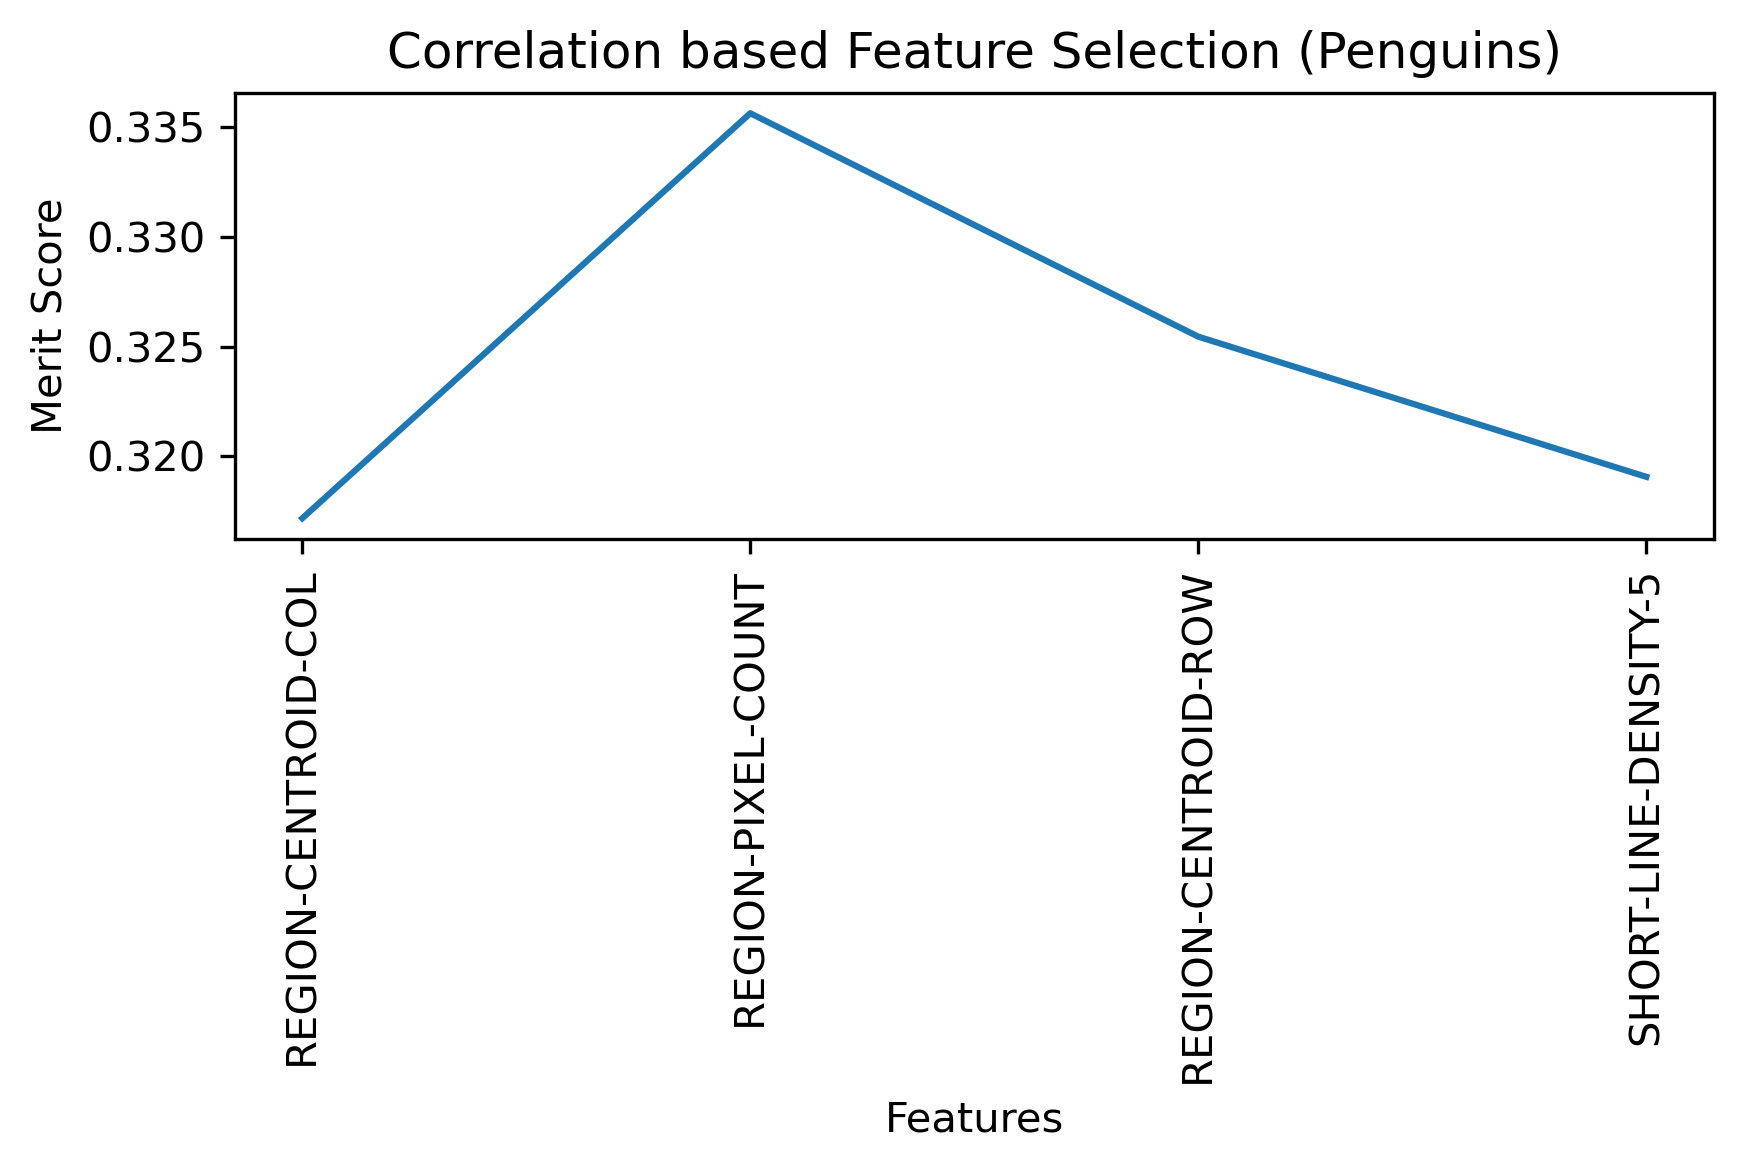

In [24]:
# Plot merit score as features are added
f1 = plt.figure(dpi = 300)
plt.plot(feature_names_sel, merit)
plt.title("Correlation based Feature Selection (Penguins)")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Merit Score")
plt.tight_layout()

#### Evaluate on Test data

In [25]:
X_test_CFS = X_test[:,Sel_feat]

kNN_CFS = kNN.fit(X_train_CFS,y_train)

y_pred = kNN_CFS.predict(X_test_CFS)

acc_CFS = accuracy_score(y_pred,y_test)
cv_acc_CFS = cross_val_score(kNN_CFS, X_train_CFS, y_train, cv=8)

print("X_Val on training selected features: {0:.3f}".format(cv_acc_CFS.mean())) 
print("Hold Out testing selected features: {0:.3f}".format(acc_CFS)) 

X_Val on training selected features: 0.988
Hold Out testing selected features: 0.982


### Plot Results

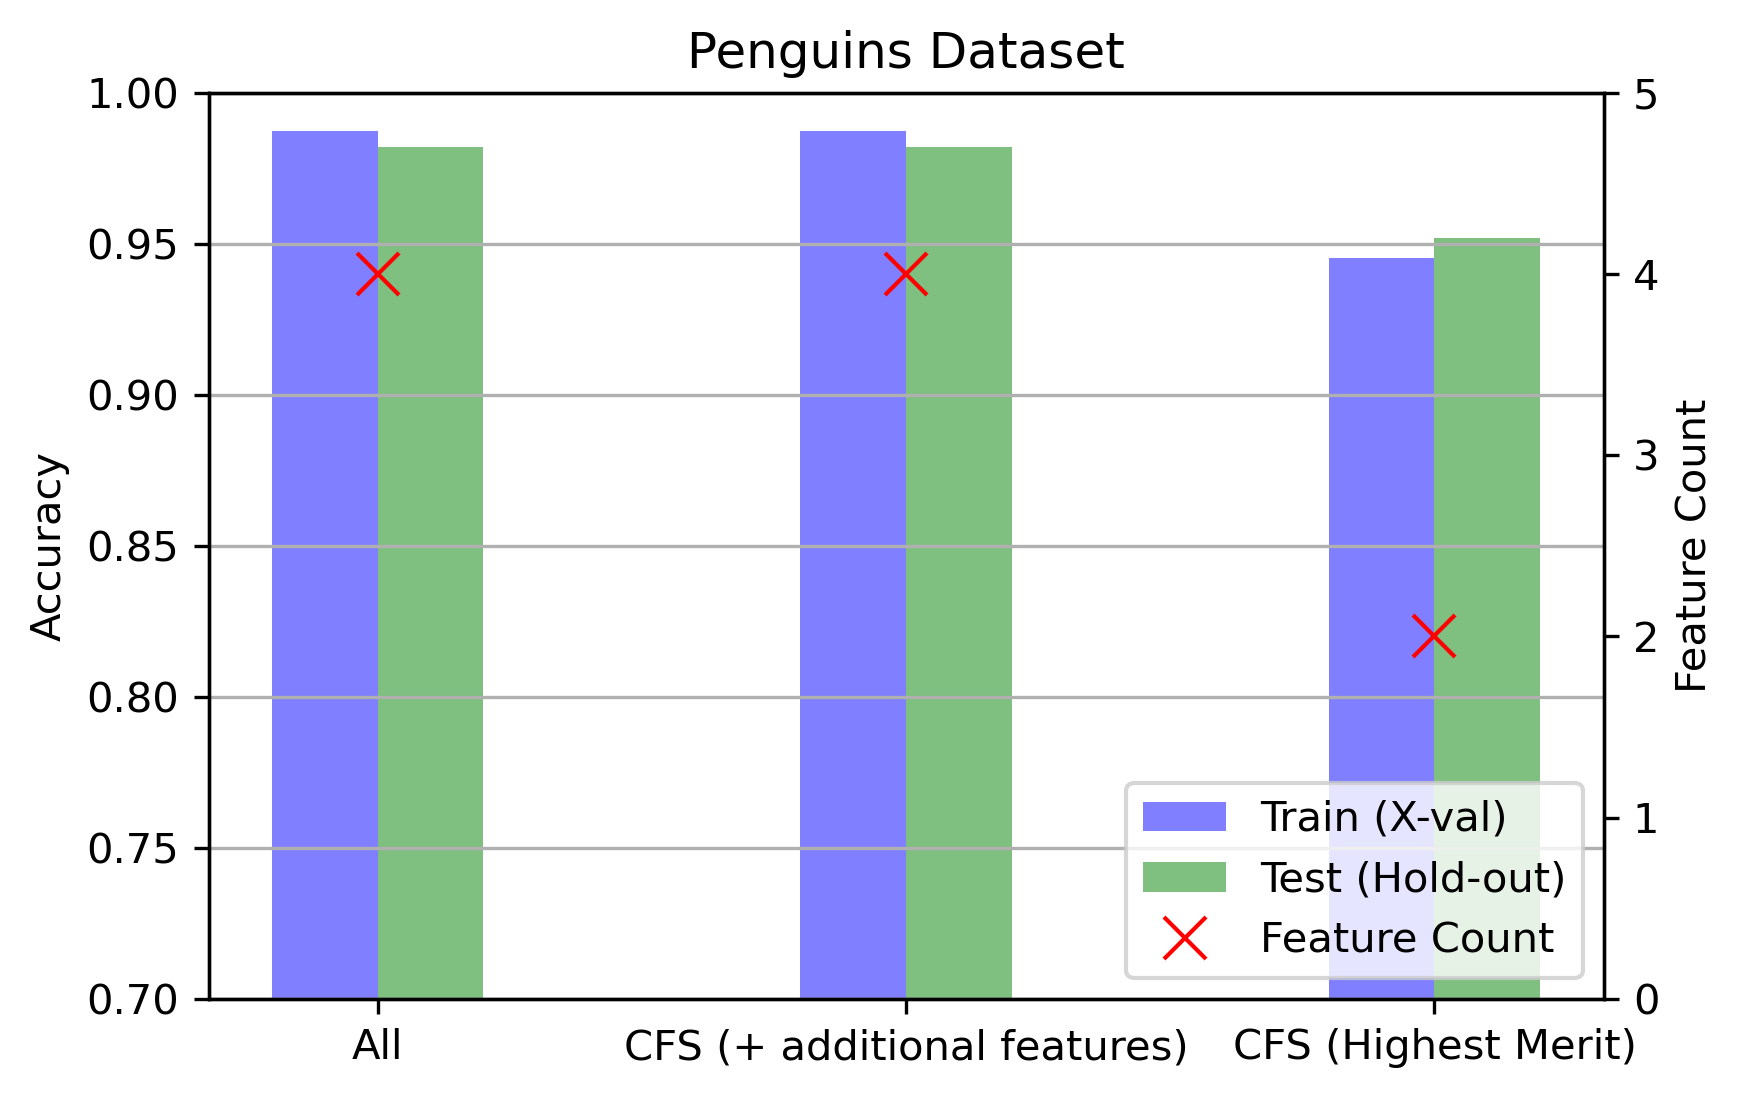

In [26]:
fig, ax = plt.subplots(dpi = 300)
width = 0.2

options = ['All', 'CFS (+ additional features)', 'CFS (Highest Merit)']
n_feat = [X_train.shape[1], X_train_CFS.shape[1], X_train_CFS_FS.shape[1]]
accs = [acc,acc_CFS, acc_CFS_FS]
xv = [cv_acc.mean(), cv_acc_CFS.mean(), cv_acc_CFS_FS.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label = 'Train (X-val)',
            color=['blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width/2, accs , width, align='center', label = 'Test (Hold-out)',
            color=['g','g','g'],alpha=0.5)

ax.set_ylim([0.7, 1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2],n_feat, color = 'red', label = 'Feature Count', marker = 'x', ms = 10, linewidth=0)
ax2.set_ylim([0, 5])

ax.grid(axis = 'y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc = 'lower right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Feature Count')
plt.title("Penguins Dataset")
plt.show()

References:

Jundong Li, Kewei Cheng, Suhang Wang, Fred Morstatter, Robert P. Trevino, Jiliang Tang, and Huan Liu. 2017. Feature Selection: A Data Perspective. ACM Comput. Surv. 50, 6, Article 94 (January 2018), 45 pages. DOI:https://doi.org/10.1145/3136625